# Flow

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspologic.utils import binarize, get_lcc, is_fully_connected
from scipy.stats import rankdata, spearmanr

import SpringRank as sr
from pkg.data import load_data
from pkg.io import savefig, set_cwd
from pkg.plot import CLASS_COLOR_DICT, set_theme
from src.visualization import adjplot  # TODO will be in graspologic

set_theme()

/Users/bpedigo/miniconda3/envs/maggot-revamp/lib/python3.8/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


In [2]:
# get the joint (union) LCC across all graphs
# this is just the LCC of the sum graph (G)
data = load_data("G")
adj = data.adj
meta = data.meta
lcc_adj, keep_inds = get_lcc(adj, return_inds=True)
# meta = meta.iloc[keep_inds]

In [3]:
graph_types = ["Gaa", "Gad", "Gda", "Gdd"]
graph_type_names = {
    "Gaa": r"$A \rightarrow A$",
    "Gad": r"$A \rightarrow D$",
    "Gda": r"$D \rightarrow A$",
    "Gdd": r"$D \rightarrow D$",
}

graphs = {}

for graph_type in graph_types:
    temp_data = load_data(graph_type)
    temp_meta = temp_data.meta
    temp_adj = temp_data.adj
    assert (temp_meta.index.values == meta.index.values).all()
    temp_adj = temp_adj[np.ix_(keep_inds, keep_inds)]
    graphs[graph_type] = temp_adj

meta = meta.iloc[keep_inds].copy()

In [4]:
for graph_type in graph_types:
    adj = graphs[graph_type]
    adj_lcc, inds = get_lcc(adj, return_inds=True)
    adj_lcc = binarize(adj_lcc)
    ranks = sr.get_ranks(adj_lcc)
    meta[f"{graph_type}_sr_score"] = np.nan
    meta[f"{graph_type}_sr_rank"] = np.nan
    meta.loc[meta.index[inds], f"{graph_type}_sr_score"] = ranks
    spring_rank = rankdata(ranks)
    meta.loc[meta.index[inds], f"{graph_type}_sr_rank"] = spring_rank

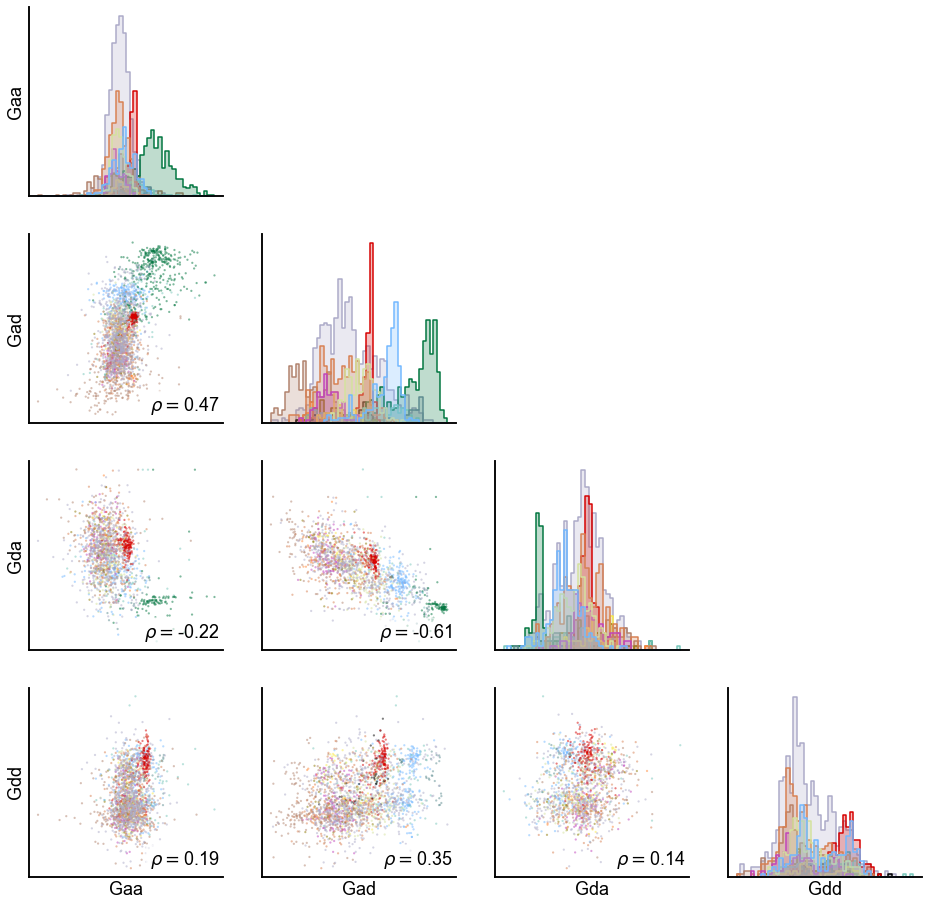

In [5]:
hue_key = "simple_class"
var = "sr_score"
n_graphs = len(graph_types)

fig, axs = plt.subplots(n_graphs, n_graphs, figsize=(16, 16))
for i, row_graph in enumerate(graph_types):
    for j, col_graph in enumerate(graph_types):

        x_var = f"{col_graph}_{var}"
        y_var = f"{row_graph}_{var}"

        spearman_corr, _ = spearmanr(meta[x_var], meta[y_var], nan_policy="omit")

        ax = axs[i, j]
        if i > j:
            sns.scatterplot(
                data=meta,
                x=x_var,
                y=y_var,
                hue=hue_key,
                palette=CLASS_COLOR_DICT,
                ax=ax,
                s=5,
                alpha=0.5,
                linewidth=0,
                legend=False,
            )
            text = ax.text(
                0.98,
                0.03,
                r"$\rho = $" + f"{spearman_corr:0.2f}",
                transform=ax.transAxes,
                ha="right",
                va="bottom",
                color="black",
            )
            text.set_bbox(dict(facecolor="white", alpha=0.6, edgecolor="w"))
        elif i == j:
            sns.histplot(
                data=meta,
                x=x_var,
                ax=ax,
                bins=50,
                element="step",
                # color="grey",
                hue=hue_key,
                palette=CLASS_COLOR_DICT,
                legend=False,
                stat="density",
                common_norm=True,
            )
        else:
            ax.axis("off")
        ax.set(xticks=[], yticks=[], xlabel="", ylabel="")
        if i == n_graphs - 1:
            ax.set(xlabel=f"{col_graph}")
        if j == 0:
            ax.set(ylabel=f"{row_graph}")
    # stashfig(f"{var}-pairwise")

In [6]:
for graph_type in graph_types:
    adj = graphs[graph_type]
    adj_lcc, inds = get_lcc(adj, return_inds=True)
    ranks = sr.get_ranks(adj_lcc)
    beta = sr.get_inverse_temperature(adj_lcc, ranks)
    print(beta)

1.1144380799117166
2.0381613667869867
3.4640518828635893
1.8371778437153456


In [7]:
A = adj_lcc.copy()

ranks = sr.get_ranks(A)
beta = sr.get_inverse_temperature(A, ranks)


def estimate_spring_rank_P(A, ranks, beta):
    H = ranks[:, None] - ranks[None, :] - 1
    H = np.multiply(H, H)
    H *= 0.5
    P = np.exp(-beta * H)
    P *= np.mean(A) / np.mean(P)  # TODO I might be off by a constant here
    return P

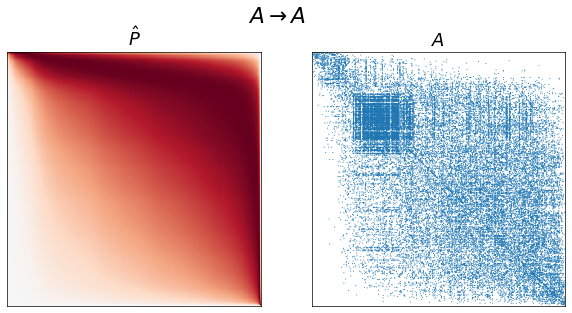

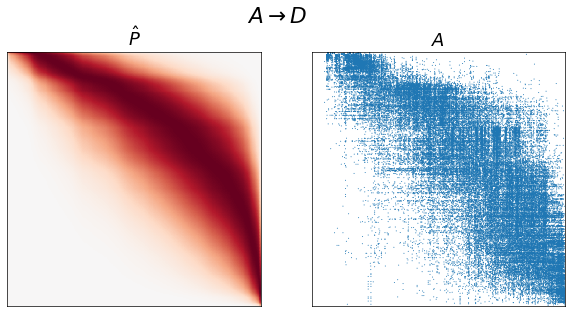

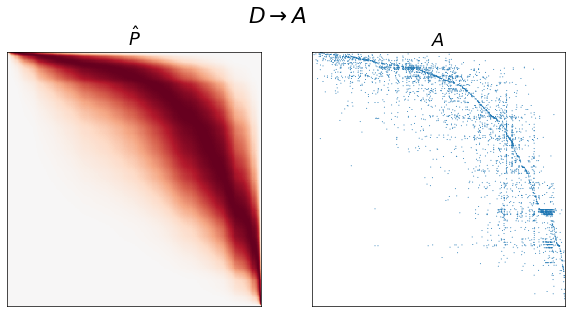

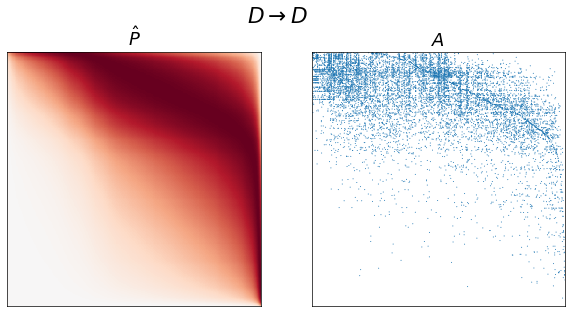

In [8]:
for graph_type in graph_types:
    adj = graphs[graph_type]
    A, inds = get_lcc(adj, return_inds=True)
    ranks = sr.get_ranks(A)
    beta = sr.get_inverse_temperature(A, ranks)
    P = estimate_spring_rank_P(A, ranks, beta)
    sort_inds = np.argsort(-ranks)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    adjplot(P[np.ix_(sort_inds, sort_inds)], ax=axs[0], cbar=False, title=r"$\hat{P}$")
    adjplot(
        A[np.ix_(sort_inds, sort_inds)],
        plot_type="scattermap",
        ax=axs[1],
        sizes=(1, 1),
        title=r"$A$",
    )
    fig.suptitle(graph_type_names[graph_type])

36366.577596313386
29401.08333698647
40627.98293932192
34908.35595505854


(<AxesSubplot:title={'center':'Sampled $A_{swap}$'}>,
 <AxesSubplot:title={'center':'Sampled $A_{swap}$'}>,
 <AxesSubplot:title={'center':'Sampled $A_{swap}$'}>)

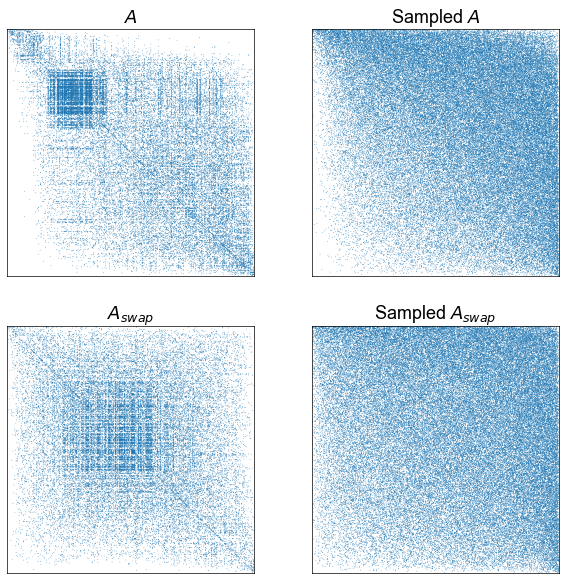

In [9]:


def swap_edges(A):
    swapped_A = A.copy()
    row_inds, col_inds = np.nonzero(A)
    uniform_rvs = np.random.uniform(size=len(row_inds))
    swap_inds_inds = np.nonzero(uniform_rvs < 0.5)
    swap_row_inds = row_inds[swap_inds_inds]
    swap_col_inds = col_inds[swap_inds_inds]
    swapped_A[swap_row_inds, swap_col_inds] = A[swap_col_inds, swap_row_inds]
    swapped_A[swap_col_inds, swap_row_inds] = A[swap_row_inds, swap_col_inds]
    # for i, (row_ind, col_ind) in enumerate(zip(row_inds, col_inds)):
    #     if uniform_rvs[i]:
    #         swapped_A[row_ind, col_ind] = A[col_ind, row_ind]
    #         swapped_A[col_ind, row_ind] = A[row_ind, col_ind]
    return swapped_A


def ground_state_energy(A, ranks, per_edge=False):
    degree_in = A.sum(axis=0)
    degree_out = A.sum(axis=1)
    edges = A.sum()
    energy = 0.5 * np.sum((degree_in - degree_out) * ranks) + 0.5 * edges
    if per_edge:
        energy /= edges
    return energy


graph_type = "Gaa"
A = graphs[graph_type].copy()
# optional thresholding
# A[A < 3] = 0
# A[A > 0] = 1
A, inds = get_lcc(A, return_inds=True)


# original adjacency
ranks = sr.get_ranks(A)
sort_inds = np.argsort(-ranks)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
print(ground_state_energy(A, ranks))
adjplot(
    A[np.ix_(sort_inds, sort_inds)],
    plot_type="scattermap",
    ax=axs[0, 0],
    sizes=(0.5, 0.5),
    title=r"$A$",
)

# sampling a network from that model
beta = sr.get_inverse_temperature(A, ranks)
P = estimate_spring_rank_P(A, ranks, beta)
sampled_A = np.random.poisson(P)

ranks = sr.get_ranks(sampled_A)
sort_inds = np.argsort(-ranks)
print(ground_state_energy(sampled_A, ranks))
adjplot(
    sampled_A[np.ix_(sort_inds, sort_inds)],
    plot_type="scattermap",
    ax=axs[0, 1],
    sizes=(0.5, 0.5),
    title=r"Sampled $A$",
)

# edge-direction swapped network
swapped_A = swap_edges(A)

ranks = sr.get_ranks(swapped_A)
sort_inds = np.argsort(-ranks)
print(ground_state_energy(swapped_A, ranks))
adjplot(
    swapped_A[np.ix_(sort_inds, sort_inds)],
    plot_type="scattermap",
    ax=axs[1, 0],
    sizes=(0.5, 0.5),
    title=r"$A_{swap}$",
)

# edge-direction swapped model
beta = sr.get_inverse_temperature(swapped_A, ranks)
P = estimate_spring_rank_P(swapped_A, ranks, beta)
sampled_swapped_A = np.random.poisson(P)

ranks = sr.get_ranks(sampled_swapped_A)
sort_inds = np.argsort(-ranks)
print(ground_state_energy(sampled_swapped_A, ranks))
adjplot(
    sampled_swapped_A[np.ix_(sort_inds, sort_inds)],
    plot_type="scattermap",
    ax=axs[1, 1],
    sizes=(0.5, 0.5),
    title=r"Sampled $A_{swap}$",
)

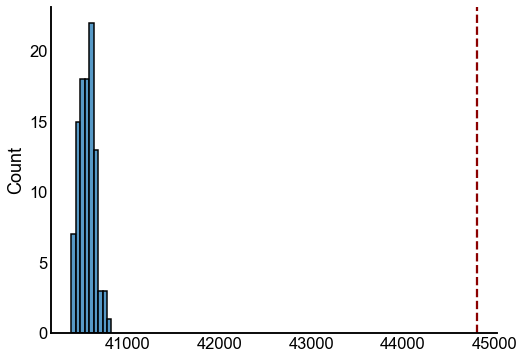

In [10]:


tstat = ground_state_energy(A, ranks)

energies = []
for i in range(100):
    # this was the wrong null
    # sampled_A = np.random.poisson(P)

    swapped_A = swap_edges(A)
    ranks = sr.get_ranks(swapped_A)
    energy = ground_state_energy(swapped_A, ranks)
    # print(is_fully_connected(swapped_A))
    #
    # bootstrapped_beta = sr.get_inverse_temperature(swapped_A, ranks)
    # print()
    energies.append(energy)


fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(energies, ax=ax)
ax.axvline(tstat, color="darkred", linestyle="--")

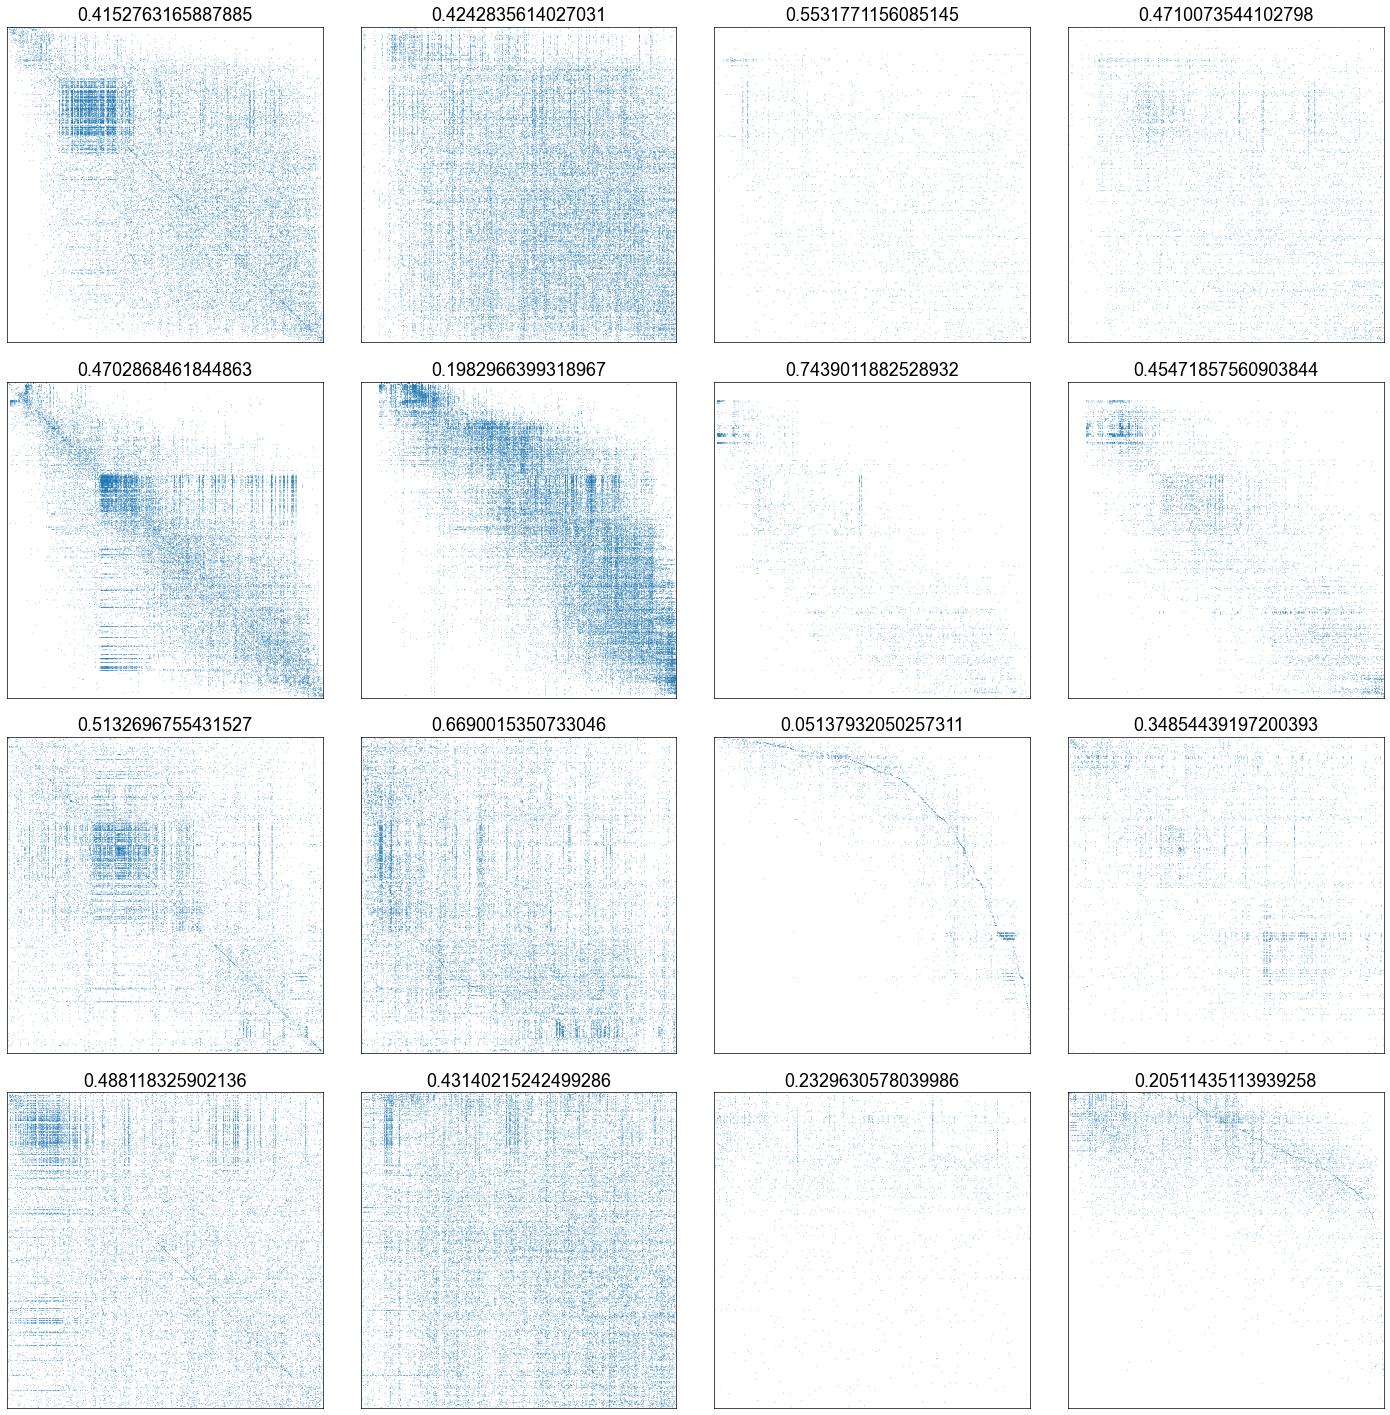

In [11]:

fig, axs = plt.subplots(4, 4, figsize=(20, 20))

for i, graph_type_source in enumerate(graph_types):
    A_source = graphs[graph_type_source].copy()
    A_source, keep_inds = get_lcc(A_source, return_inds=True)

    # original adjacency
    ranks = sr.get_ranks(A_source)
    sort_inds = np.argsort(-ranks)
    for j, graph_type_target in enumerate(graph_types):
        A_target = graphs[graph_type_target].copy()
        A_target = A_target[np.ix_(keep_inds, keep_inds)]
        adjplot(
            A_target[np.ix_(sort_inds, sort_inds)],
            plot_type="scattermap",
            ax=axs[i, j],
            sizes=(0.4, 0.4),
            # title=r"$A$",
            title=ground_state_energy(A_target, ranks, per_edge=True),
        )
        # print()
plt.tight_layout()

In [12]:

from tqdm import tqdm


def histplot(data, x=None, hue=None, ax=None, **kwargs):
    sizes = data.groupby(hue).size()
    single_hues = np.unique(sizes[sizes == 1].index)
    single_data = data[data[hue].isin(single_hues)]
    other_data = data[~data[hue].isin(single_hues)]
    sns.histplot(other_data, x=x, hue=hue, ax=ax, **kwargs)
    for idx, row in single_data.iterrows():
        x_val = row[x]
        ax.axvline(x_val, color="darkred", linestyle="--", linewidth=2)


def calculate_p_triu(A):
    # TODO is this correct?
    triu_inds = np.triu_indices(len(A), k=1)
    n_A_upper = A[triu_inds].sum()
    n_A_lower = A[triu_inds[::-1]].sum()
    p_A_upper = n_A_upper / (n_A_lower + n_A_upper)
    return p_A_upper


rows = []
for i, graph_type_source in enumerate(graph_types):
    A_source = graphs[graph_type_source].copy()
    A_source, keep_inds = get_lcc(A_source, return_inds=True)

    # original adjacency
    ranks = sr.get_ranks(A_source)
    sort_inds = np.argsort(-ranks)

    for j, graph_type_target in enumerate(graph_types):
        A_target = graphs[graph_type_target].copy()
        A_target = A_target[np.ix_(keep_inds, keep_inds)]

        energy = ground_state_energy(A_target, ranks, per_edge=True)
        # p_upper = calculate_p_triu(A_target[np.ix_(sort_inds, sort_inds)])
        rows.append(
            {
                "energy": energy,
                "type": "Observed",
                "graph_type_source": graph_type_source,
                "graph_type_target": graph_type_target,
                # "p_upper": p_upper,
            }
        )

        for _ in tqdm(range(100), desc=f"{graph_type_source}, {graph_type_target}"):
            swapped_A_target = swap_edges(A_target)
            # ranks = sr.get_ranks(swapped_A) # dont use old ranks, use ones from
            # "source" graph
            energy = ground_state_energy(swapped_A_target, ranks, per_edge=True)
            # p_upper = calculate_p_triu(swapped_A_target[np.ix_(sort_inds, sort_inds)])
            rows.append(
                {
                    "energy": energy,
                    "type": "Swapped",
                    "graph_type_source": graph_type_source,
                    "graph_type_target": graph_type_target,
                    # "p_upper": p_upper,
                }
            )

Gdd, Gdd: 100%|██████████| 100/100 [00:05<00:00, 17.72it/s]


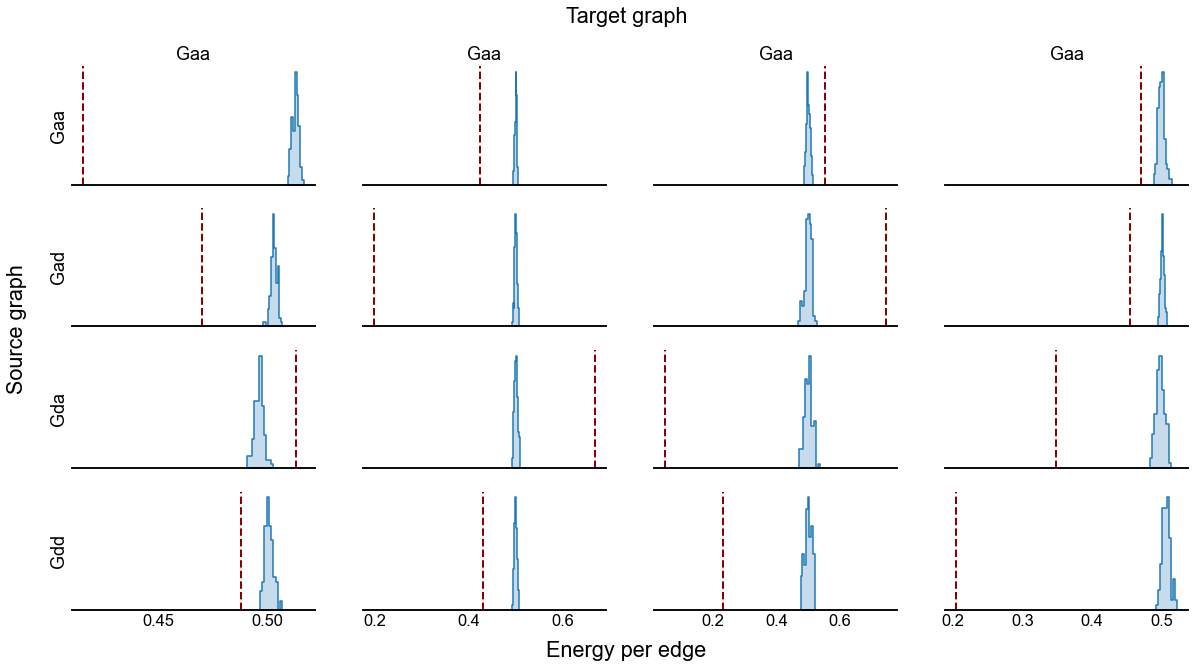

In [13]:
results = pd.DataFrame(rows)

fig, axs = plt.subplots(4, 4, figsize=(20, 10), sharex="col")
for i, graph_type_source in enumerate(graph_types):
    for j, graph_type_target in enumerate(graph_types):
        sub_results = results[
            (results["graph_type_source"] == graph_type_source)
            & (results["graph_type_target"] == graph_type_target)
        ]
        ax = axs[i, j]
        histplot(
            data=sub_results,
            x="energy",
            hue="type",
            ax=ax,
            stat="density",
            element="step",
        )
        ax.get_legend().remove()
        ax.set(yticks=[], ylabel="", xlabel="")
        ax.spines["left"].set_visible(False)

        if j == 0:
            ax.set(ylabel=graph_type_source)
        if i == 0:
            ax.set(title=graph_type_source)

fig.text(0.51, 0.94, "Target graph", fontsize="large", ha="center")
fig.text(0.08, 0.43, "Source graph", rotation=90, fontsize="large")
fig.text(0.51, 0.06, "Energy per edge", fontsize="large", ha="center")

savefig("energy-densities", foldername="flow_rank")